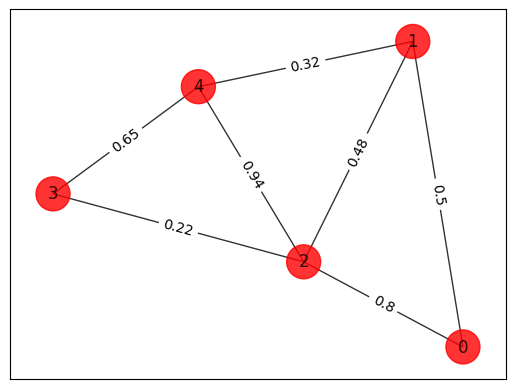

In [120]:
from collections import defaultdict
from typing import List, Tuple
import time

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import matplotlib.pyplot as plt

import networkx as nx

import numpy as np

from classical_solver import qubo_min_cost_partition, get_partitions

# Generating a graph of 4 nodes

n = 5  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

weights   = [0.5, 0.8, 0.32, 0.94, 0.22, 0.65, 0.48]
edge_list = [(0, 1, weights[0]),
             (0, 2, weights[1]),
             (1, 4, weights[2]),
             (2, 4, weights[3]),
             (2, 3, weights[4]),
             (3, 4, weights[5]),
             (1, 2, weights[6])]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edge_list)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


DISPLAY_GRAPH = True
if DISPLAY_GRAPH:
    draw_graph(G, colors, pos)
    plt.show()



In [121]:
def generate_Q(size: int, edges: List[Tuple[int, int, float]]) -> np.ndarray:
    """
    :param size: number of nodes in graph.
    :param edges: list of edges w. corresponding weight.
    :return: connectivity matrix of QUBO model, i.e. Q in x^TQx.
    """
    _Q = np.zeros(shape=(size, size), dtype=float)
    for _i, _j, _w in edges:
        _Q[_i, _j] += 2*_w
        _Q[_i, _i] -= 1*_w
        _Q[_j, _j] -= 1*_w
    return _Q

In [122]:
# ------- Set up our QUBO dictionary -------
# Get matrix from graph
init_Q = generate_Q(size=n, edges=edge_list)

# Initialize our Q matrix
Q = defaultdict(int)

# Update Q dictionary
for i in range(init_Q.shape[0]):
    for j in range(init_Q.shape[1]):
        Q[(i,j)]+= init_Q[i,j]

# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
chainstrength = 160
numruns = 20

# Run the QUBO on the solver from your config file
qpu = DWaveSampler()
print("Using: ", qpu.solver.id)
sampler = EmbeddingComposite(qpu)

print("Starting D-Wave annealing...")
start = time.time()

response = sampler.sample_qubo(Q,
                               chain_strength=chainstrength,
                               num_reads=numruns)
print(response.info)
print(f"D-Wave annealing done in {time.time() - start} seconds.")


Using:  Advantage_system4.1
Starting D-Wave annealing...
{'timing': {'qpu_sampling_time': 2050.4, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 61.98, 'qpu_access_time': 17809.17, 'qpu_access_overhead_time': 8303.83, 'qpu_programming_time': 15758.77, 'qpu_delay_time_per_sample': 20.54, 'post_processing_overhead_time': 1868.0, 'total_post_processing_time': 1868.0}, 'problem_id': 'cb0ce69d-c869-404b-9da3-7370eab54eed'}
D-Wave annealing done in 2.9617249965667725 seconds.


    ### DWAVE RESULTS ###
------------------------------
   Partition       Energy
------------------------------
[1. 0. 0. 0. 1.]    -3.21    
[0. 0. 1. 1. 0.]    -2.87    
[0. 1. 1. 0. 0.]    -2.78    


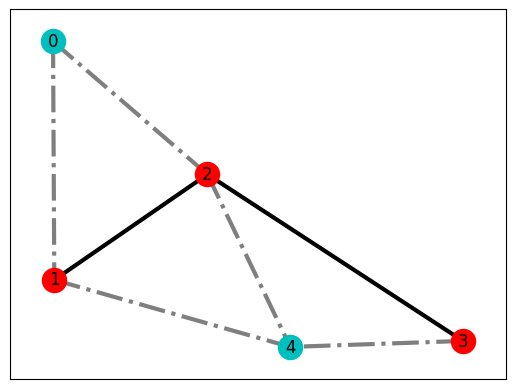

In [123]:
# ------- Print results to user -------
print("    ### DWAVE RESULTS ###")
print('-' * 30)
print('{:>12s}{:>13s}'.format('Partition','Energy'))
print('-' * 30)
max_states, counter = 3, 0
for sample, E in response.data(fields=['sample','energy']):
    if counter < max_states:
        S1 = np.array([k for k,v in sample.items() if v == 1],dtype=int)
        state = np.zeros(shape=(n,))
        state[S1] = 1
        #print(sample.items())
        print('{:>12s}{:^13s}'.format(str(state),str(np.round(E,5))))
    counter += 1

# ------- Display results to user -------
# Grab best result
lut = response.first.sample

# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if not lut[node]]
S1 = [node for node in G.nodes if lut[node]]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)
plt.show()

### Using classical optimal solver

In [124]:
all_partitions = get_partitions(size=n)
min_cost, min_partition = qubo_min_cost_partition(partitions=all_partitions,Q_mat=init_Q)

 ### CLASSICAL SOLVER RESULTS ###
-----------------------------------
Optimal partition   Optimal energy
-----------------------------------
[1, 0, 0, 0, 1]        -3.21         


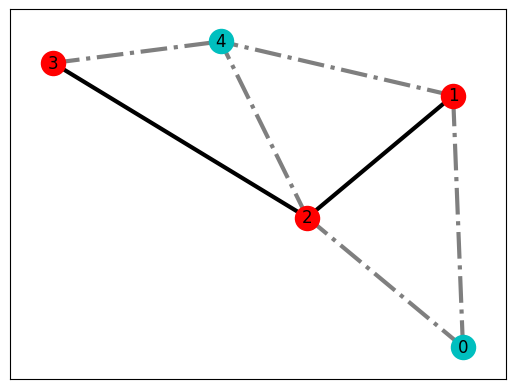

In [125]:
print(" ### CLASSICAL SOLVER RESULTS ###")
print("-"*35)
print("Optimal partition   Optimal energy")
print("-"*35)
print('{:>12s}{:^22s}'.format(str(list(min_partition)),str(np.round(min_cost,5))))

# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if list(min_partition)[node] == 0]
S1 = [node for node in G.nodes if list(min_partition)[node] == 1]
cut_edges = [(u, v) for u, v in G.edges if list(min_partition)[u]!=list(min_partition)[v]]
uncut_edges = [(u, v) for u, v in G.edges if list(min_partition)[u]==list(min_partition)[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)
plt.show()